# Problem 11.1

**Integrated Energy Grids**

**Problem 11.1. Join capacity and dispatch optimization.**

This is an extension of Problem 8.1 from Lecture 8 in which only the electricity sector was included.

**Optimize the capacity and dispatch of solar PV, onshore wind, battery, and heat pumps to supply the inelastic electricity and heating demand throughout one year. Assume that a Combined Heat and Power (CHP) unit with capacity of 1GW exist in the system. To do this, take the time series for the [wind](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and [solar](https://zenodo.org/record/2613651#.X0kbhDVS-uV) capacity factors for Portugal in 2015 and the [electricity demand](https://github.com/martavp/integrated-energy-grids/tree/main/integrated-energy-grids/Problems/data).**


**To estimate the hourly heating demand, consider the [population-weighted temperature time series](https://github.com/martavp/integrated-energy-grids/tree/main/integrated-energy-grids/Problems/data). Assume an annual heating demand for space heating and hot water of of 11,500 GWh/a and 8760 GWh/a respectively and a threshold temperature $T_{th}$=17$^{\circ}$C.**

**Consider the annualized capital costs and marginal generation costs for the different technologies in the table.**


**The annualized capital cost of the battery comprises  12,894 EUR/MWh/a for the energy capacity and 24,678 EUR/MW/a for the inverter. The inverter efficiency is 0.96 and the battery is assumed to have a fixed energy-to-power ratio of 2 hours. The Coefficient of Performance (COP) of heat pumps can be estimated as $COP (\Delta T) = 6.81 - 0.121 \Delta T + 0.00063 \Delta T^2$ where  $\Delta T = T_{sink} - T_{source}$ and $T_{sink}$=55 $^{\circ}$C. The  CHP unit can be modelled usig a multilink and assuming an efficiency of 0.4 when producing electricity and 0.4 when producing heat, assuming a marginal cost of 80 EUR/MWh and adding a gas store to the gas bus that represents an unlimited supply of gas.**

**Calculate the total system cost, the optimal installed capacities, the annual generation per technology, and plot the hourly generation and demand of electricity and heat during January.**

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `numpy` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [53]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [54]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [55]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [56]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [57]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [58]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [59]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onshore wind and solar.

In [60]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

101644.12332388277

In [61]:
costs.at["solar", "capital_cost"] #EUR/MW/a

51346.82981964593

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [62]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

data_T = pd.read_csv('data/temperature.csv',sep=';')
data_T.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [63]:
data_T.head()

,utc_time,PRT
utc_time,,
2015-01-01 00:00:00+00:00,2015-01-01T00:00:00Z,5.8
2015-01-01 01:00:00+00:00,2015-01-01T01:00:00Z,5.4
2015-01-01 02:00:00+00:00,2015-01-01T02:00:00Z,5.2
2015-01-01 03:00:00+00:00,2015-01-01T03:00:00Z,4.9
2015-01-01 04:00:00+00:00,2015-01-01T04:00:00Z,4.5


We will use timeseries for Portugal in this excercise

In [64]:
country = 'PRT'

### Join capacity and dispatch optimization

For building the model, we start again by initialising an empty network, adding the snapshots, the electricity and the heating bus.

In [65]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus", "electricity")
n.add("Bus", "heat")

n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

Next, we add the demand time series to the model.

In [66]:
# add load to the bus
n.add("Load",
      "electricity demand",
      bus="electricity",
      p_set=data_el[country].values)

Index(['electricity demand'], dtype='object')

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

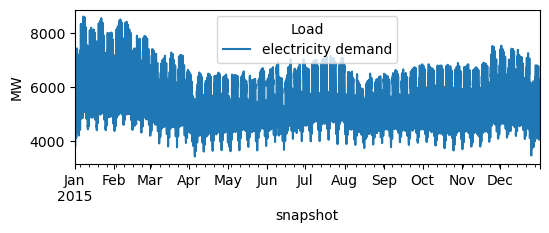

In [67]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We estimated now the hourly heating demand, based on the annual demand, the population-weighted temperature and the threshold temperature.

<Axes: xlabel='utc_time'>

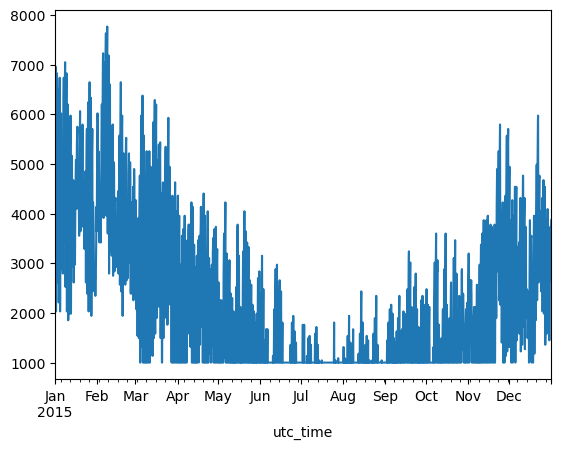

In [68]:
T_th=17 #ºC
annual_space_heating = 11500000 #GWh/a 
annual_hot_water = 8760000 #GWh/a

HDH=T_th-data_T['PRT']
HDH[HDH<0]=0

scale=annual_space_heating/HDH.sum()
heating_demand=scale*HDH+annual_hot_water/8760
heating_demand.plot()

We can add the heating demand to the model and plot it to check that it was properly added. 

<Axes: xlabel='snapshot', ylabel='MW'>

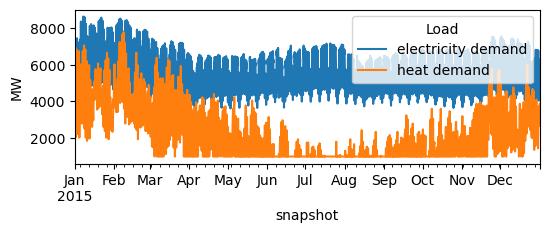

In [69]:
# add load to the bus
n.add("Load",
      "heat demand",
      bus="heat",
      p_set=heating_demand.values)

n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the generators and set up their capacities to be extendable so that they can be optimized together with the dispatch time series. For the wind and solar generator, we need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [70]:
CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "onwind",
        bus="electricity",
        carrier="onwind",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "solar",
        bus="electricity",
        carrier="solar",
        p_max_pu= CF_solar.values,
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

Index(['solar'], dtype='object')

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

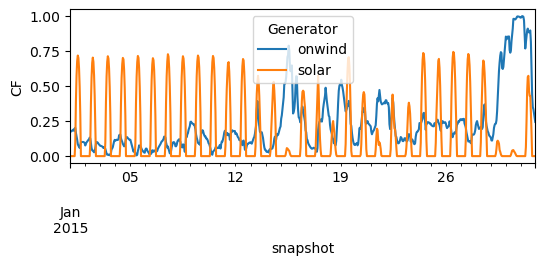

In [71]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

We add the battery storage, assuming a fixed energy-to-power ratio of 2 hours, i.e. if fully charged, the battery can discharge at full capacity for 2 hours. 

For capital costs, we have to factor in both the capacity and energy costs of storage. 

We include the charging and discharging efficiencies we enforce a cyclic state-of-charge condition, i.e. the state of charge at the beginning of the optimisation period must equal the final state of charge.

In [72]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Index(['battery storage'], dtype='object')

We add now the CPH unit assuming a constant efficiency for power and heat generator using a multilink and a store of gas with unlimited capacity

In [73]:
n.add("Bus", "gas")

# We add a gas store with energy capacity and an initial filling level much higher than the required gas consumption, 
# this way gas supply is unlimited
n.add("Store", "gas", e_initial=1e6, e_nom=1e6, bus="gas") 

n.add(
    "Link",
    "CHP",
    bus0="gas",
    bus1="electricity",
    bus2="heat",
    p_nom=1000,
    marginal_cost=80,
    efficiency=0.4,
    efficiency2=0.4,
)

Index(['CHP'], dtype='object')

In order to add the air heat pumps to the network. 

We calculate their time-dependent COP with a sink temperature of 55° C and the population-weighted ambient temperature profile for Portugal.

The heat pump performance is given by the following function:

$$
COP(\Delta T) = 6.81 - 0.121 \Delta T + 0.00063 \Delta T^2
$$
where $\Delta T = T_{sink} - T_{source}$.


In [74]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 6.81 - 0.121 * delta_t + 0.00063 * delta_t**2

temp=data_T[country]


We add the heat pump to the network and plot to check that it was propoerly added. 

<Axes: xlabel='snapshot', ylabel='COP'>

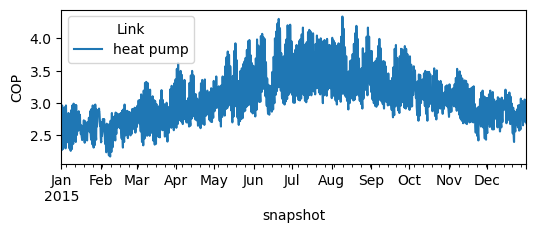

In [75]:
n.add(
    "Link",
    "heat pump",
    carrier="heat pump",
    bus0="electricity",
    bus1="heat",
    efficiency=cop(temp).values,
    p_nom_extendable=True,
    capital_cost=costs.at["central air-sourced heat pump", "capital_cost"],  # €/MWe/a
)

n.links_t.efficiency.plot(figsize=(6, 2), ylabel="COP")

### Model Run

We can already solved the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [76]:
n.optimize(solver_name="highs")

Index(['electricity', 'heat', 'gas'], dtype='object', name='Bus')
Index(['onwind', 'solar'], dtype='object', name='Generator')
Index(['gas'], dtype='object', name='Store')
Index(['CHP', 'heat pump'], dtype='object', name='Link')
Index(['battery storage'], dtype='object', name='StorageUnit')
Index(['electricity', 'heat', 'gas'], dtype='object', name='Bus')
Index(['onwind', 'solar'], dtype='object', name='Generator')
Index(['gas'], dtype='object', name='Store')
Index(['CHP', 'heat pump'], dtype='object', name='Link')
Index(['battery storage'], dtype='object', name='StorageUnit')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 10/10 [00:00<00:00, 25.43it/s]
INFO:linopy.io: Writing time: 2.28s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78844 primals, 183964 duals
Objective: 7.45e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimi

('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [77]:
n.objective / 1e9

7.445154948946167

The optimised capacities in GW, notice that we are representing some technologies using generators componenets and other using heat components, so we need to check both.

In [78]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

Generator
onwind    17.646024
solar     47.929947
Name: p_nom_opt, dtype: float64

In [79]:
n.links.p_nom_opt.div(1e3)

Link
CHP          1.000000
heat pump    3.407656
Name: p_nom_opt, dtype: float64

The total energy generation by technology in TWh:

In [80]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

Generator
onwind     6.131049
solar     52.108982
dtype: float64

Electricity generation CHP

In [81]:
-n.links_t.p1['CHP'].sum()*0.000001  # MWh -> TWh

0.1559091618395015

Heat generation from CHP and heat pumps

In [82]:
-n.links_t.p2['CHP'].sum()*0.000001  # MWh -> TWh

0.1559091618395015

In [83]:
-n.links_t.p1['heat pump'].sum()*0.000001  # MWh -> TWh

20.104090838163273

We can plot the dispatch of electricity from every generator throughout January

<Axes: xlabel='snapshot', ylabel='dispatch'>

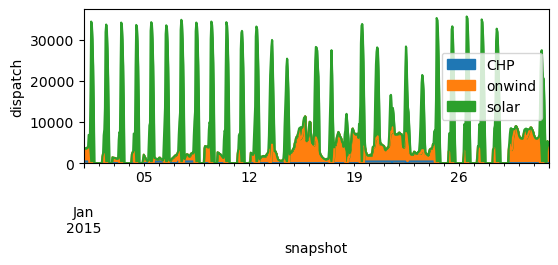

In [84]:
pd.concat([-n.links_t.p1['CHP'].loc["2015-01"], n.generators_t.p.loc["2015-01"],], axis=1).plot.area(figsize=(6, 2), ylabel="dispatch")

We can also plot the dispatch of heating from every generator throughout January

<Axes: xlabel='snapshot', ylabel='dispatch'>

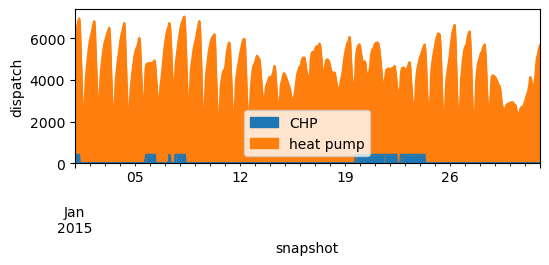

In [85]:
pd.concat([-n.links_t.p2['CHP'].loc["2015-01"],-n.links_t.p1['heat pump'].loc["2015-01"]], axis=1).plot.area(figsize=(6, 2), ylabel="dispatch")

We can also plot the annual electricity mix and heating mix

<Axes: title={'center': 'Electricity'}>

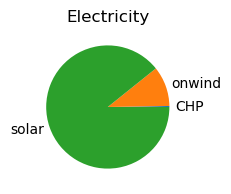

In [86]:
pd.concat([-n.links_t.p1['CHP'], n.generators_t.p], axis=1).sum().plot.pie(figsize=(6, 2), title='Electricity')

<Axes: title={'center': 'Heat'}>

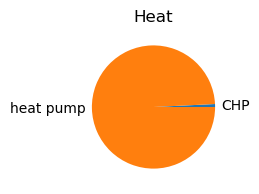

In [87]:
pd.concat([-n.links_t.p2['CHP'],-n.links_t.p1['heat pump']], axis=1).sum().plot.pie(figsize=(6, 2), title='Heat')